## Connectome head curvature circuit

In [1]:
using NeuroPALData, DelimitedFiles, ANTSUNData, HDF5, JSON, PyPlot,
    PyCall, Statistics, Combinatorics, LinearAlgebra, FlavellBase, NaNMath,
    Distances, StatsBase, Random, Suppressor, LinearAlgebra, ProgressMeter,
    FlavellConstants, EncoderModelGen, HypothesisTests,
    CePNEMAnalysis, YAML, Clustering, JLD2, Distributions, MultipleTesting,
    KernelDensity, ConnectomePlot, Colors, HierarchicalPosteriorModel, GLM, DataFrames
zstd = FlavellBase.standardize

rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out");
    ax = gca(); ax[:xaxis][:tick_bottom]();
    ax[:yaxis][:tick_left]();
    ax[:spines]["top"]["set_visible"](false);
    ax[:spines]["right"]["set_visible"](false););

WebIO._IJuliaInit()

In [2]:
path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2/figure4/hc_circuit/"
mkpath(path_fig_root)

"/data1/prj_kfc/figure/manuscript/cell_draft2/figure4/hc_circuit"

In [3]:
py_scipy = pyimport("scipy")
py_nx = pyimport("networkx")
py_copy = pyimport("copy");

In [4]:
θh_pos_is_ventral = YAML.load_file("/data1/prj_kfc/data/data_constant/pos_is_ventral.yaml");

## Data

### Load data

In [5]:
list_uid_baseline = sort(["2022-06-14-01", "2022-06-14-07",
    "2022-06-14-13", "2022-06-28-01", "2022-06-28-07",
    "2022-07-15-06", "2022-07-15-12",
    "2022-07-20-01", "2022-07-26-01", "2022-08-02-01",
    "2023-01-09-28", "2023-01-17-01", "2023-01-19-01",
    "2023-01-19-08", "2023-01-19-15", "2023-01-19-22",
    "2023-01-23-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21",
    "2023-03-07-01"])

list_uid_heat = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18",
    "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08",
    "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14",
    "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15",
    "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"] |> sort;
# short: "2022-05-17-01", "2022-05-17-06"

In [6]:
list_uid = vcat(list_uid_baseline, list_uid_heat); length(list_uid)

40

In [7]:
list_data_dict = []
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    path_data = "/scratch/prj_kfc/processed_h5/$(data_uid)-data.h5"
    data_dict = import_data(path_data, custom_keys=["neuropal_registration"])

    push!(list_data_dict, data_dict)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


### Load NeuroPAL

In [8]:
list_neuropal_label = load("/scratch/prj_kfc/list_neuropal_label.jld2")["list_neuropal_label"];

In [9]:
# path_h5_enc = "/data1/prj_kfc/data/gen_analysis_data/2022-10-14-neuropal-enc.h5"
path_h5_enc = "/scratch/prj_kfc/2023-03-31-neuropal-baseline-enc.h5"
path_h5_enc_heat = "/scratch/prj_kfc/2023-03-07-neuropal-heatstim-enc.h5"
list_dict_fit = []

@showprogress for uid = list_uid
    if uid in list_uid_baseline
        push!(list_dict_fit, h5read(path_h5_enc, uid))
    elseif uid in list_uid_heat
        push!(list_dict_fit, h5read(path_h5_enc_heat, uid))        
    else
        error("$uid does not exist")
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


In [10]:
list_neuropal_order_info = readdlm("/data1/prj_neuropal/data/neuropal_label_prj_kfc/NeuroPAL order LR.csv",',');

In [11]:
list_class_dv = get_list_class_dv(map(x->x[1],list_neuropal_label));

In [12]:
list_class_ordered = generate_list_class_custom_order(list_neuropal_order_info, list_class_dv);

┌ Warning: class ASE is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL1 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL2 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class RMH is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SAAD is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SABV is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100


In [13]:
list_class_classify_dv_enc = ["SIA","SMB"] # classify based on D/V tuning

2-element Vector{String}:
 "SIA"
 "SMB"

In [14]:
list_match_dict = get_list_match_dict(list_neuropal_label, list_data_dict=list_data_dict, list_dict_fit=list_dict_fit,
    list_class_ordered=list_class_ordered,
    list_class_classify_dv_enc=list_class_classify_dv_enc, θ_confidence_label=2.5);

In [15]:
list_uid_no_pumping = h5read(path_h5_enc, "list_uid_invalid_pt")
list_uid_pumping = setdiff(list_uid, list_uid_no_pumping)
list_idx_uid_pumping = [idx_uid for idx_uid = 1:length(list_uid) if list_uid[idx_uid] in list_uid_pumping];

In [16]:
list_class_dv_ordered = let
    list_all_class = unique(vcat(map(x->collect(keys(x[2])), list_match_dict)...))
    list_intersect = intersect(map(x->x[2], list_class_ordered), list_all_class)
    println("missing (in the ordering file but not in the matches): ", setdiff(setdiff(map(x->x[2], list_class_ordered), list_all_class)))
    println("n(class): $(length(list_intersect))")
    list_intersect
end;

missing (in the ordering file but not in the matches): Any["AVG", "RIG", "DB02", "DD01", "VB01", "ADF"]
n(class): 97


In [17]:
function get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit; θ_pumping=0.5)
    list_all = Tuple{String,Vector{Int}}[]
    list_pumping = Tuple{String,Vector{Int}}[]
    
    for (i_uid, uid) = enumerate(list_uid)
        lattice_range_p = list_dict_fit[i_uid]["lattice_range"]["P"]
        
        q_heat = uid in list_uid_heat
        rg_t = q_heat ? Int[1] : 1:length(lattice_range_p)
        
        list_rg_t_all = Int[]
        list_rg_t_pumping = Int[]
        
        for i_rg_t = rg_t
            # check pumping variance
            lattice_p = lattice_range_p["$i_rg_t"]
            if abs(lattice_p[2] - lattice_p[1]) .> θ_pumping
                push!(list_rg_t_pumping, i_rg_t)
            end
            
            push!(list_rg_t_all, i_rg_t)
        end
        
        push!(list_all, (uid, list_rg_t_all))
        push!(list_pumping, (uid, list_rg_t_pumping))
    end
    
    list_all, list_pumping
end

list_uid_use_all, list_uid_use_pumping = get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit);

## Connectome

### Connectome - White et al L/R

In [18]:
g_wh_lr = get_graph_white(0)
ensory_wh_lr, list_muscle_wh_lr = get_sensory_muscle(g_wh_lr);

In [19]:
g_wh_lr_p = get_graph_white_p(0)
list_sensory_wh_lr_p, list_muscle_wh_lr_p = get_sensory_muscle(g_wh_lr_p);

In [20]:
g_wv = get_graph_witvliet(2, merge_lr=true)
# list_sensory_wv, list_muscle_wv = get_sensory_muscle(g_wv);

g_wv_lr = get_graph_witvliet(2);
# list_sensory_wv_lr, list_muscle_wv_lr = get_sensory_muscle(g_wv_lr);

In [21]:
dict_pos_z_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_z_non_p...)
dict_pos_v2_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v2_non_p...)
dict_pos_v3_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v3_non_p...)

dict_pos_z_p = Base.ImmutableDict(ConnectomePlot.dict_pos_z_p...)
dict_pos_v2_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v2_p...)
dict_pos_v3_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v3_p...)

dict_pos_v2_patch, dict_pos_z_patch = get_dict_pos_patched();

### HB model fit

In [22]:
function shuffle_dict_feature(dict_feature)
    shuffled = typeof(dict_feature)()
    
    ks = collect(keys(dict_feature))
    ks_shuffled = shuffle(ks)
    
    for (k,k_new) = zip(ks, ks_shuffled)
        shuffled[k_new] = dict_feature[k]
    end
    
    shuffled
end

shuffle_dict_feature (generic function with 1 method)

In [23]:
extrapolated_behaviors = load("/data1/prj_neuropal/data/extrapolated_behaviors.jld2")["extrapolated_behaviors"];
eb_n_t = size(extrapolated_behaviors,1)
eb_list_b = [extrapolated_behaviors[:,i] for i = 1:3];
hb_model_result = load("/data1/prj_neuropal/data/hierarchical_dict.jld2")["hierarchical_dict"]
hb_model_rel_enc = load("/data1/prj_neuropal/data/hierarchical_relative_encoding_strength.jld2")["hierarchical_relative_encoding_strength"];

In [24]:
dict_ps = hb_model_result["hierarchical_model_params"]
dict_distribution = Dict{String,Dict{String,Vector{Float64}}}()
for (class, dict_ps) = dict_ps
    ps_mu = dict_ps.mu
    ps_sigma = dict_ps.sigma

    ps_mu = vcat(ps_mu[1], exp(ps_mu[2]), ps_mu[3:end])
    ps_sigma = exp.(ps_sigma)

    dict_distribution[class] = Dict("mu"=>ps_mu, "sigma"=>ps_sigma)
end

In [25]:
hb_tuning = load("/data1/prj_neuropal/data/hierarchical_tunings_zstd.jld2")["hierarchical_tunings"];

## Plot

In [26]:
default_node_size = 400
n_min_synapse_chemical = 1
n_min_synapse_electrical = 1

1

### nodes

In [27]:
dict_node = Dict{String,Dict}()
id_to_node_label = Dict{Int,String}()
node_label_to_id = Dict{String,Int}()

dict_node["RMED"] = Dict("pos"=>(2,0), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMEV"] = Dict("pos"=>(-2,0), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMEL"] = Dict("pos"=>(0,-4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMER"] = Dict("pos"=>(0,4), "size"=>default_node_size, "node_type"=>"neuron")

dict_node["RMDVL"] = Dict("pos"=>(4,-4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMDVR"] = Dict("pos"=>(4, 4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMDDL"] = Dict("pos"=>(-4,-4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMDDR"] = Dict("pos"=>(-4, 4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMDL"] = Dict("pos"=>(0, -2), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["RMDR"] = Dict("pos"=>(0, 2), "size"=>default_node_size, "node_type"=>"neuron")

dict_node["SMDVL"] = Dict("pos"=>(5.25, -2), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SMDVR"] = Dict("pos"=>(5.25, 2), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SMDDL"] = Dict("pos"=>(-5.25, -2), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SMDDR"] = Dict("pos"=>(-5.25, 2), "size"=>default_node_size, "node_type"=>"neuron")

dict_node["SMBVL"] = Dict("pos"=>(6.5, -4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SMBVR"] = Dict("pos"=>(6.5, 4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SMBDL"] = Dict("pos"=>(-6.5, -4), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SMBDR"] = Dict("pos"=>(-6.5, 4), "size"=>default_node_size, "node_type"=>"neuron")

dict_node["SAAVL"] = Dict("pos"=>(5.25, -6), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SAAVR"] = Dict("pos"=>(5.25, 6), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SAADL"] = Dict("pos"=>(-5.25, -6), "size"=>default_node_size, "node_type"=>"neuron")
dict_node["SAADR"] = Dict("pos"=>(-5.25, 6), "size"=>default_node_size, "node_type"=>"neuron")

for i = 3:7
    dict_node["BWM-DL0$i"] = Dict("pos"=>(-9, -2.), "size"=>default_node_size, "node_type"=>"muscle")
    dict_node["BWM-DR0$i"] = Dict("pos"=>(-9, 2.), "size"=>default_node_size, "node_type"=>"muscle")
    dict_node["BWM-VL0$i"] = Dict("pos"=>(9, -2.), "size"=>default_node_size, "node_type"=>"muscle")
    dict_node["BWM-VR0$i"] = Dict("pos"=>(9, 2.), "size"=>default_node_size, "node_type"=>"muscle")
end

dict_node["BWM-DL"] = Dict("pos"=>(-9, -2.), "size"=>default_node_size, "node_type"=>"muscle_group")
dict_node["BWM-DR"] = Dict("pos"=>(-9, 2.), "size"=>default_node_size, "node_type"=>"muscle_group")
dict_node["BWM-VL"] = Dict("pos"=>(9, -2.), "size"=>default_node_size, "node_type"=>"muscle_group")
dict_node["BWM-VR"] = Dict("pos"=>(9, 2.), "size"=>default_node_size, "node_type"=>"muscle_group")


let
    i_node = 1
    for (k,v) = dict_node
        id_to_node_label[i_node] = k
        v["id"] = i_node
        
        node_label_to_id[k] = i_node
        
        i_node += 1
    end
end

In [28]:
list_synapses = let
    data_connectome1 = ConnectomePlot.data_connectome_witvliet_7
    data_connectome2 = ConnectomePlot.data_connectome_witvliet_8
    list_neuron = sort(collect(keys(dict_node)))
    list_synapses = Tuple{Int,Int,String,Int}[]
    for presynaptic = list_neuron, postsynaptic = list_neuron
        n_synapse_electrical = 0
        n_synapse_chemical = 0
        for data = [data_connectome1, data_connectome2]
            list_edges = filter(x->x["pre"] == presynaptic && x["post"] == postsynaptic, data)
            if length(list_edges) > 0
                for edge = list_edges
                    edge_type = edge["typ"] == 0 ? "chemical" : "electrical"
                    #0: chemical synapse 2: electrical synapse (gap junction)
                    edge_count = sum(edge["syn"])
                    
                    if edge_type == "chemical"
                        n_synapse_chemical += edge_count
                    else
                        n_synapse_electrical += edge_count
                    end
                end # edge list
            end # if length(list_edges)
        end # data
        if n_synapse_chemical >= n_min_synapse_chemical
            push!(list_synapses, (node_label_to_id[presynaptic], node_label_to_id[postsynaptic], "chemical", n_synapse_chemical))
        end
        if n_synapse_electrical >= n_min_synapse_electrical
            push!(list_synapses, (node_label_to_id[presynaptic], node_label_to_id[postsynaptic], "electrical", n_synapse_electrical))
        end
    end # neuron
    
    list_synapses
end;

list_synapses # (pre, post, type, # synapses)

245-element Vector{Tuple{Int64, Int64, String, Int64}}:
 (7, 37, "electrical", 2)
 (25, 32, "electrical", 1)
 (37, 7, "electrical", 2)
 (32, 25, "electrical", 1)
 (40, 11, "electrical", 1)
 (35, 30, "electrical", 2)
 (35, 36, "electrical", 1)
 (38, 33, "electrical", 1)
 (5, 27, "electrical", 1)
 (29, 8, "electrical", 1)
 (30, 35, "electrical", 2)
 (16, 44, "electrical", 1)
 (10, 44, "electrical", 1)
 ⋮
 (21, 10, "chemical", 2)
 (21, 14, "electrical", 1)
 (21, 44, "electrical", 2)
 (21, 20, "chemical", 1)
 (21, 24, "chemical", 1)
 (21, 17, "chemical", 12)
 (45, 35, "chemical", 4)
 (45, 38, "chemical", 1)
 (45, 5, "chemical", 4)
 (45, 29, "chemical", 1)
 (45, 36, "electrical", 2)
 (45, 24, "chemical", 16)

In [29]:
list_neuron_head_manifest = [
      ("RMD","L"),
        ("RMD","R"),
        ("RMDV","L"),
        ("RMDV","R"),
        ("RMDD","L"),
        ("RMDD","R"),
        ("RME","L"),
        ("RME","R"),
        ("RMED",nothing),
        ("RMEV",nothing),
        ("SMDV","L"),
        ("SMDV","R"),
        ("SMDD","L"),
        ("SMDD","R"),
        ("SMBD","L"),
        ("SMBD","R"),
        ("SMBV","L"),
        ("SMBV","R"),
        
        ("SAADL",nothing), # already split in match dict
        ("SAADR",nothing), # already split in match dict
        ("SAAV","L"),
        ("SAAV","R")
];

### feature compute

In [30]:
dict_dorsal_fwd, dict_dorsal_rev, dict_fwd, dict_rev = let
    enc_dor_fwd = Dict()
    enc_dor_rev = Dict()
    enc_fwd = Dict()
    enc_rev = Dict()

    for (idx_uid, (uid, rg_t)) = enumerate(list_uid_use_all)
        dict_fit = list_dict_fit[idx_uid]
        dict_match = list_match_dict[idx_uid][2]
        
        for rg_t = rg_t
            dict_ts = dict_fit["tuning_strength"]["$rg_t"]
            for (idx_class, (class_dv, class_lr)) = enumerate(list_neuron_head_manifest)
                neuron_match = nothing
                class_full = if isnothing(class_lr)
                    class_dv
                else
                    class_dv * class_lr
                end
                
                if haskey(dict_match, class_dv)
                    list_match = if isnothing(class_lr)
                        dict_match[class_dv]
                    else
                        filter(x->(x[1]["LR"] == class_lr), dict_match[class_dv])
                    end   
                    
                    if length(list_match) == 0
                        # no match
                    elseif length(list_match) == 1
                        neuron_match = list_match[1]
                    else
                        error("multiple label found")
                    end
                    
                    if !isnothing(neuron_match)
                        (label, roi_gcamp, match_confidence) = neuron_match
                        dict_ts_neuron = dict_ts["$roi_gcamp"]
                        
                        fwd_slope = dict_ts_neuron["v_encoding"][1,2,1,1]
                        rev_slope = dict_ts_neuron["v_encoding"][3,4,1,1]
                        
                        add_list_dict!(enc_fwd, class_full, fwd_slope)
                        add_list_dict!(enc_rev, class_full, rev_slope)
                        add_list_dict!(enc_dor_fwd, class_full, dict_ts_neuron["fwd_θh_encoding_dorsal"])
                        add_list_dict!(enc_dor_rev, class_full, dict_ts_neuron["rev_θh_encoding_dorsal"])
                    end
                end # if haskey(class_dv)
            end # for list_classes for lr
        end # for rg_t
    end # for list_uid_use_t_all

    
    dict_dorsal_fwd, dict_dorsal_rev, dict_fwd, dict_rev = Dict(), Dict(), Dict(), Dict()
    
    for k = keys(enc_dor_fwd)
        dict_dorsal_fwd[k] = mean(enc_dor_fwd[k])
        dict_dorsal_rev[k] = mean(enc_dor_rev[k])
        dict_fwd[k] = mean(enc_fwd[k])
        dict_rev[k] = mean(enc_rev[k])
    end
    
    dict_dorsal_fwd, dict_dorsal_rev, dict_fwd, dict_rev
end;

### Plot - default

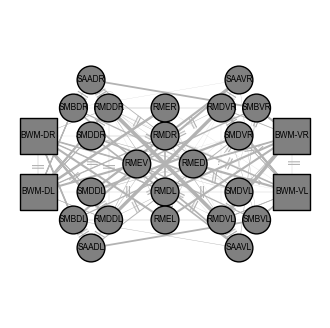

In [31]:
let
    ### color map
    cmax = 1
    cmin = 0
    cmap = ColorMap("PiYG")
    vmin, vmax = -7,7

    ### size
    size_max = default_node_size + 500
    size_min = default_node_size - 250
    
    slope_max = 15
    slope_min = -15

    
    ### graph
    g_head = py_nx.Graph(edge_layout="curved")
    for (k,v) = dict_node
        g_head.add_node(v["id"], pos=v["pos"], node_size=v["size"], node_label=k, node_type=v["node_type"])
    end
    
    for synapse = list_synapses
        g_head.add_edge(synapse[1], synapse[2], weight=synapse[4], synapse_type=synapse[3])
    end
    
    node_pos = py_nx.get_node_attributes(g_head, "pos")
    node_size = [dict_node[id_to_node_label[i]]["size"] for i = 1:length(id_to_node_label)]
    node_label = py_nx.get_node_attributes(g_head,"node_label")
    
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "neuron"
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
    
            # color
            push!(list_node_color, (0.5,0.5,0.5,1))
            
            # size
            push!(list_node_size, default_node_size)
            push!(list_node_edgecolors, (0,0,0,1))
        else 
            push!(list_node_color, zeros(4))
            push!(list_node_size, default_node_size)
            push!(list_node_edgecolors, zeros(4))
        end
    end
    
    figure(figsize=(4,4))
    #### nodes
    py_nx.draw_networkx_nodes(g_head, node_pos, node_size=list_node_size, node_color=list_node_color, edgecolors=list_node_edgecolors)
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="arial", font_weight="normal")
    
    #### edges
    g_edges = g_head.edges
    list_chemical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "chemical"]
    list_electrical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "electrical"]
    
    ## marking gap junction/electrical synapse with ||
    dict_edge_label = Dict()
    for (u,v) = g_edges
        if g_edges.get((u,v))["synapse_type"] == "electrical"
            dict_edge_label[(u,v)] = "||"
        end
    end
    py_nx.draw_networkx_edge_labels(g_head, node_pos, dict_edge_label,
        font_family="arial", font_weight="normal", font_color=(0.7,0.7,0.7,1))

    ## electrical
    py_nx.draw_networkx_edges(g_head, node_pos, style="-", arrows=false, edge_color=(0.7,0.7,0.7,1),
        edgelist=[(u,v) for (u,v) = list_electrical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_electrical])
    ## chemical
    py_nx.draw_networkx_edges(g_head, node_pos, arrows=false, edge_color=(0.7,0.7,0.7,1),
        edgelist=[(u,v) for (u,v) = list_chemical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_chemical])

    #### node - muscle group
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    list_node = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "muscle_group"
            push!(list_node, i)
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
            
            push!(list_node_color, (0.5,0.5,0.5,1))
            push!(list_node_size, 1.75*default_node_size)
            push!(list_node_edgecolors, (0,0,0,1))
        end
    end
    py_nx.draw_networkx_nodes(g_head, dict_pos_node_neuron, nodelist=list_node,
        node_size=list_node_size, node_color=list_node_color,
        edgecolors=list_node_edgecolors, node_shape="s")
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="arial", font_weight="normal")

    
    # #### other image settings
    axis("off")
    ylim(-11,11)
    xlim(-11,11)
    # tight_layout()
    path_fig = joinpath(path_fig_root, "hc_circuit_default")
    savefig(path_fig * ".png", dpi=300)
    savefig(path_fig * ".pdf")    
end

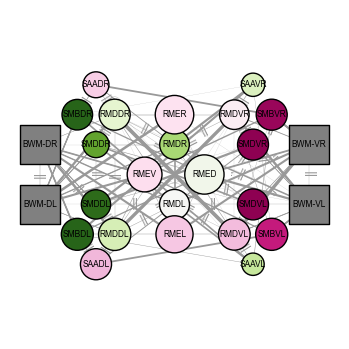

In [32]:
let
     ### color map
    cmax = 1
    cmin = 0
    cmap = ColorMap("PiYG")
    vmin, vmax = -0.25,0.25

    ### size
    size_max = default_node_size + 400
    size_min = default_node_size - 250
    
    slope_max = 4
    slope_min = -4

    
    ### graph
    g_head = py_nx.Graph(edge_layout="curved")
    for (k,v) = dict_node
        g_head.add_node(v["id"], pos=v["pos"], node_size=v["size"], node_label=k, node_type=v["node_type"])
    end
    
    for synapse = list_synapses
        g_head.add_edge(synapse[1], synapse[2], weight=synapse[4], synapse_type=synapse[3])
    end
    
    node_pos = py_nx.get_node_attributes(g_head, "pos")
    node_size = [dict_node[id_to_node_label[i]]["size"] for i = 1:length(id_to_node_label)]
    node_label = py_nx.get_node_attributes(g_head,"node_label")
    
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "neuron"
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
    
            # color
            x_ = dict_dorsal_fwd[node_label_]
            x_ = clamp(x_, vmin, vmax)
            x_ = (cmax - cmin) * (x_ - vmin) / (vmax - vmin) + cmin
            push!(list_node_color, cmap(x_))
            
            # size
            x_ = dict_fwd[node_label_]
            x_ = clamp(x_, slope_min, slope_max)
            x_ = (size_max - size_min) * (x_ - slope_min) / (slope_max - slope_min) + size_min
            push!(list_node_size, x_)
            push!(list_node_edgecolors, (0,0,0,1))
        else 
            push!(list_node_color, zeros(4))
            push!(list_node_size, default_node_size)
            push!(list_node_edgecolors, zeros(4))
        end
    end
    
    figure(figsize=(3.5,3.5))
    #### nodes
    py_nx.draw_networkx_nodes(g_head, node_pos, node_size=list_node_size, node_color=list_node_color, edgecolors=list_node_edgecolors)
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="arial", font_weight="normal")
    
    #### edges
    g_edges = g_head.edges
    list_chemical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "chemical"]
    list_electrical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "electrical"]
    
    ## marking gap junction/electrical synapse with ||
    dict_edge_label = Dict()
    for (u,v) = g_edges
        if g_edges.get((u,v))["synapse_type"] == "electrical"
            dict_edge_label[(u,v)] = "||"
        end
    end
    py_nx.draw_networkx_edge_labels(g_head, node_pos, dict_edge_label,
        font_family="Arial", font_weight="normal" , font_color=(0.6,0.6,0.6,1))

    ## electrical
    py_nx.draw_networkx_edges(g_head, node_pos, style="-", arrows=false, edge_color=(0.6,0.6,0.6,1),
        edgelist=[(u,v) for (u,v) = list_electrical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_electrical])
    ## chemical
    py_nx.draw_networkx_edges(g_head, node_pos, arrows=false, edge_color=(0.6,0.6,0.6,1),
        edgelist=[(u,v) for (u,v) = list_chemical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_chemical])

    #### node - muscle group
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    list_node = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "muscle_group"
            push!(list_node, i)
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
            
            push!(list_node_color, (0.5,0.5,0.5,1))
            push!(list_node_size, 2*default_node_size)
            push!(list_node_edgecolors, (0,0,0,1))
        end
    end
    py_nx.draw_networkx_nodes(g_head, dict_pos_node_neuron, nodelist=list_node,
        node_size=list_node_size, node_color=list_node_color,
        edgecolors=list_node_edgecolors, node_shape="s")
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="Arial", font_weight="normal")

    
    #### other image settings
    axis("off")
    ylim(-11,11)
    xlim(-11,11)
    tight_layout()
    path_fig = joinpath(path_fig_root, "hc_circuit_forward")
    savefig(path_fig * ".png", dpi=300)
    savefig(path_fig * ".pdf")    
end

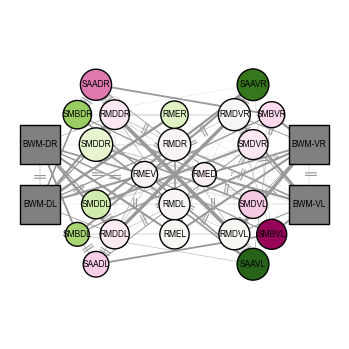

In [33]:
let
    ### color map
    cmax = 1
    cmin = 0
    cmap = ColorMap("PiYG")
    vmin, vmax = -0.25,0.25

    ### size
    size_max = default_node_size + 400
    size_min = default_node_size - 250
    
    slope_max = 4
    slope_min = -4

    ### graph
    g_head = py_nx.Graph(edge_layout="curved")
    for (k,v) = dict_node
        g_head.add_node(v["id"], pos=v["pos"], node_size=v["size"], node_label=k, node_type=v["node_type"])
    end
    
    for synapse = list_synapses
        g_head.add_edge(synapse[1], synapse[2], weight=synapse[4], synapse_type=synapse[3])
    end
    
    node_pos = py_nx.get_node_attributes(g_head, "pos")
    node_size = [dict_node[id_to_node_label[i]]["size"] for i = 1:length(id_to_node_label)]
    node_label = py_nx.get_node_attributes(g_head,"node_label")
    
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "neuron"
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
    
            # color
            x_ = dict_dorsal_rev[node_label_]
            x_ = clamp(x_, vmin, vmax)
            x_ = (cmax - cmin) * (x_ - vmin) / (vmax - vmin) + cmin
            push!(list_node_color, cmap(x_))
            
            # size
            x_ = - dict_rev[node_label_]
            x_ = clamp(x_, slope_min, slope_max)
            x_ = (size_max - size_min) * (x_ - slope_min) / (slope_max - slope_min) + size_min
            push!(list_node_size, x_)
            push!(list_node_edgecolors, (0,0,0,1))
        else 
            push!(list_node_color, zeros(4))
            push!(list_node_size, default_node_size)
            push!(list_node_edgecolors, zeros(4))
        end
    end
    
    figure(figsize=(3.5,3.5))
    #### nodes
    py_nx.draw_networkx_nodes(g_head, node_pos, node_size=list_node_size, node_color=list_node_color, edgecolors=list_node_edgecolors)
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="Arial", font_weight="normal")
    
    #### edges
    g_edges = g_head.edges
    list_chemical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "chemical"]
    list_electrical = [(u,v) for (u,v) = g_edges if g_edges.get((u,v))["synapse_type"] == "electrical"]
    
    ## marking gap junction/electrical synapse with ||
    dict_edge_label = Dict()
    for (u,v) = g_edges
        if g_edges.get((u,v))["synapse_type"] == "electrical"
            dict_edge_label[(u,v)] = "||"
        end
    end
    py_nx.draw_networkx_edge_labels(g_head, node_pos, dict_edge_label,
        font_family="Arial", font_weight="normal", font_color=(0.6,0.6,0.6,1))

    ## electrical
    py_nx.draw_networkx_edges(g_head, node_pos, style="-", arrows=false, edge_color=(0.6,0.6,0.6,1),
        edgelist=[(u,v) for (u,v) = list_electrical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_electrical])
    ## chemical
    py_nx.draw_networkx_edges(g_head, node_pos, arrows=false, edge_color=(0.6,0.6,0.6,1),
        edgelist=[(u,v) for (u,v) = list_chemical],
        width=[g_edges.get((u,v))["weight"] / 10 for (u,v) = list_chemical])

    #### node - muscle group
    dict_pos_node_neuron = Dict()
    dict_label_node_neuron = Dict()
    list_node_color = []
    list_node_size = []
    list_node_edgecolors = []
    list_node = []
    for i = 1:length(g_head.nodes)
        node_ = g_head.nodes.get(i)
        if node_["node_type"] == "muscle_group"
            push!(list_node, i)
            dict_pos_node_neuron[i] = node_["pos"]
            node_label_ = node_["node_label"]
            dict_label_node_neuron[i] = node_label_
            
            push!(list_node_color, (0.5,0.5,0.5,1))
            push!(list_node_size, 2*default_node_size)
            push!(list_node_edgecolors, (0,0,0,1))
        end
    end
    py_nx.draw_networkx_nodes(g_head, dict_pos_node_neuron, nodelist=list_node,
        node_size=list_node_size, node_color=list_node_color,
        edgecolors=list_node_edgecolors, node_shape="s")
    py_nx.draw_networkx_labels(g_head, dict_pos_node_neuron, labels=dict_label_node_neuron,
        font_size=6, font_family="arial", font_weight="normal")

    #### other image settings
    axis("off")
    ylim(-11,11)
    xlim(-11,11)
    tight_layout()
    path_fig = joinpath(path_fig_root, "hc_circuit_reverse")
    savefig(path_fig * ".png", dpi=300)
    savefig(path_fig * ".pdf")    
end